In [1]:
import sys
import os
import numpy as np

project_path = os.path.abspath(os.path.join('..', '..'))

if project_path not in sys.path:
    sys.path.append(project_path)

import multilayer_dispersion as md
from multilayer_dispersion import MagneticFilm, MagneticTensor, Dispersion, μ0, Graphs

In [2]:
mu0 = μ0
layers = 2
film = MagneticFilm(number_of_layers=layers, total_thickness = 30e-9)
fp = film.magnetic_parameters

spacer, spacer_pos = .6e-9, 15e-9

d0 = film.layer_thickness/2
dx = film.layer_thickness
s_eta = np.int64((spacer_pos-d0)/dx)

xi_funct = lambda eta: (eta+1/2)*dx  + ( 0 if eta <=s_eta else spacer)
fp.define_funct("xi", xi_funct)


# Ms is the same on all layers
fp.define_funct("Ms", lambda eta: 1.21e6)
fp.define_funct("Aex", lambda eta: 1e-11)
fp.define_interlayer_interaction("J", (2/film.layer_thickness)*fp.Aex_array) 

# RKKY between layers is -3e-5 J/m2

fp.J_array[s_eta+1,s_eta] = fp.J_array[s_eta,s_eta+1] = -((9.1e-4)*1/4)

# magnetization is in-plane
fp.define_funct("th", lambda eta: np.pi/2)
fp.define_funct("gamma", lambda eta: 1.89e11)


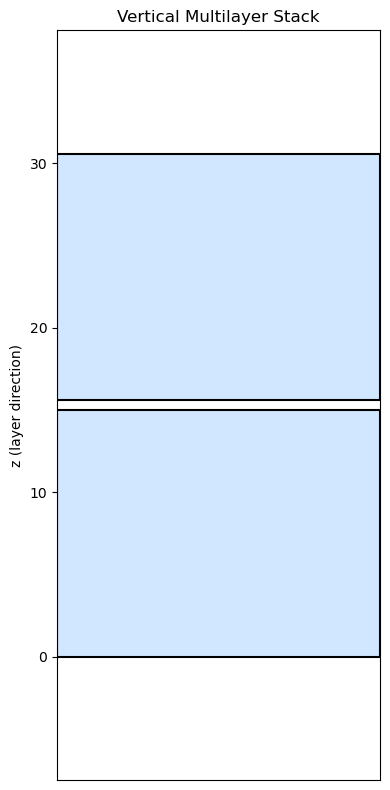

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_multilayers_vertical(xi_array, d, layer_color="#d0e7ff"):
    """
    Plot a multilayer system where each layer is vertical in ordering:
    Layers are stacked along the y-axis (vertical).
    Each layer spans y ∈ [xi[i] - d/2, xi[i] + d/2].
    All layers share the same color.
    Horizontal boundaries are drawn in black.
    """

    fig, ax = plt.subplots(figsize=(4, 8))

    for xi in xi_array:
        y0 = xi - d/2      # bottom of the layer
        rect = Rectangle((0, y0), 1, d,
                         facecolor=layer_color,
                         edgecolor="black",
                         linewidth=1.5)
        ax.add_patch(rect)

    # Plot settings
    ax.set_xlim(0, 1)
    ax.set_ylim(min(xi_array) - d, max(xi_array) + d)
    ax.set_xticks([])
    ax.set_ylabel("z (layer direction)")
    ax.set_title("Vertical Multilayer Stack")

    plt.tight_layout()
    plt.show()


# Example
xi_array = fp.xi_array*1e9
d = dx*1e9
plot_multilayers_vertical(xi_array, d)



In [19]:
data = np.load("d1=15_d2=15_rkk=-9.1e-4.npz")

Mode = "L"

H_vals = data["H_vals"]
psi1_vals = data["psi1_vals"]
psi2_vals = data["psi2_vals"]


wH_vals = []
H_clean = []
for i in range(len(H_vals)):
    H = H_vals[i]
    psi_down = psi1_vals[i]
    psi_up = psi2_vals[i]
    phi_H = 0

    if Mode == "T":
        psi_down += np.pi/2
        psi_up += np.pi/2
        phi_H = np.pi/2

    fp.phi_array = np.array([psi_down if eta <=s_eta else psi_up for eta in range(film.number_of_layers)])
    dispersion = Dispersion(film)

    k0 = np.array([-5])
    
    th_H = np.pi/2
    w_vals, v_vals = dispersion.w_vect(k0, H, th_H, phi_H)
    if len(w_vals.flatten()) != film.number_of_layers:
       print("Error: on value H =", 1e3*H*mu0, 'mT')
       print(fp.phi_array)
       continue
    wH_vals.append(w_vals.flatten())
    wH_vals.append(-w_vals.flatten())
    H_clean.append(H)
    H_clean.append(-H)
wH_vals = np.array(wH_vals)
H_vals = np.array(H_clean)

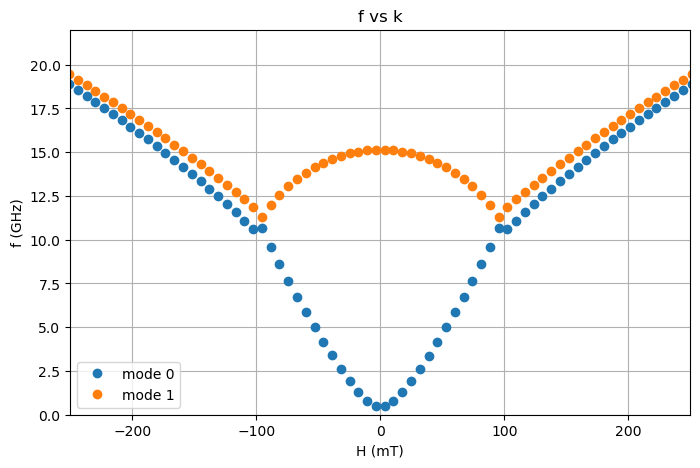

In [20]:
graphs = Graphs()
orbit_parameters = [0,0]
graphs.graph(H_vals*μ0*1e3, [wH_vals], modes = [0,1], xlim = [-250,250], ylim = [0,22], x_label='H (mT)')# , v_k_mode = orbit_parameters)

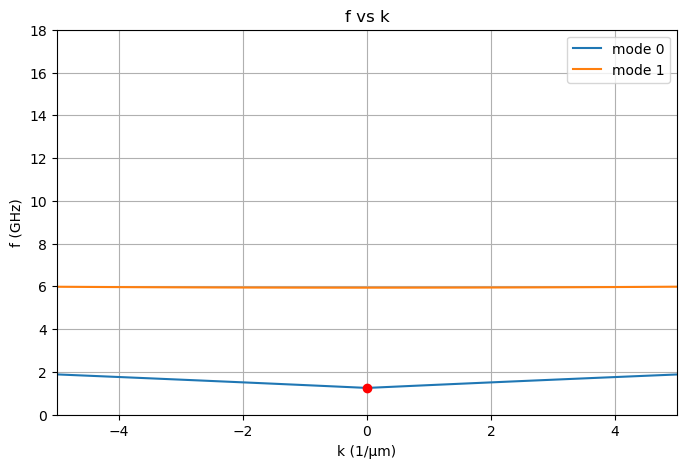

In [32]:
H_vals = data["H_vals"]
psi1_vals = data["psi1_vals"]
psi2_vals = data["psi2_vals"]

Mode = "T"
mu0H = 10 # (mT)

idx = np.abs(mu0*H_vals*1e3 - mu0H).argmin()

H = H_vals[idx]

if Mode == "T":
    phi_H = np.pi/2
    psi_down = psi1_vals[idx] + np.pi/2
    psi_up = psi2_vals[idx] + np.pi/2
elif Mode == "L":
    phi_H = 0
    psi_down = psi1_vals[idx]
    psi_up = psi2_vals[idx]

fp.phi_array = np.array([psi_down if eta<= spacer_pos else psi_up for eta in range(film.number_of_layers)])

dispersion = Dispersion(film)

th_H = np.pi/2
k = np.linspace(-5,5,100)
w_vals, v_vals = dispersion.w_vect(k, H, th_H, phi_H)
orbit_parameters = [0,0]
graphs.dispersion(-k, [w_vals], modes = [0,1], xlim=[-5,5], ylim = [0,18],  v_k_mode = orbit_parameters)
# graphs.orbits(*orbit_parameters,v_vals)